In [144]:
import numpy as np
from tqdm import tqdm ## Tqdm is a Python library that provides fast, extensible progress bars for loops and iterable
from skimage.io import imread
from skimage.transform import resize
import os
seed = 42
np.random.seed = seed

In [146]:
### Setting image dimensions

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

### Data Preprocessing 

In [149]:
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next (os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [151]:


# Define image dimensions and number of channels
IMG_HEIGHT = 128  # replace with your desired height
IMG_WIDTH = 128   # replace with your desired width
IMG_CHANNELS = 3  # for RGB images

# Paths
TRAIN_PATH = 'stage1_train/'  # replace with your actual training path
TEST_PATH = 'stage1_test/'  # replace with actual training IDs

train_ids = next(os.walk(TRAIN_PATH)) [1]
test_ids = next(os.walk(TEST_PATH)) [1]


# Creating empty arrays for images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)  # for binary masks

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_ ## entering the foulder
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS] ## in the given path -- go inside images and look at the png file
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)  ## and resize that png file to 128,128, 3
    X_train[n] = img  # Fill X_train with resized images ### and then went down to empty array [X_train] and fill it with coming from img
    
    # Create an empty mask array for each image
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  # Combine masks by taking the maximum value at each pixel

    Y_train[n] = mask  # Fill Y_train with the combined mask --- in every if there is a cell , it means it's 1 else 0.

    

    
        
        
    
                    

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:49<00:00,  3.94it/s]


In [155]:
### Do the above for test images --- we do not have any mast for test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
size_test = []

print('Resizing testing images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_ ## entering the foulder
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS] ## in the given path -- go inside images and look at the png file
    size_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_test[n] = img

print(" Done! ")



### For test images , go the folder and images and then resize them 128, 128, 






Resizing testing images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 74.47it/s]

 Done! 


### Let's check the images before training the model 

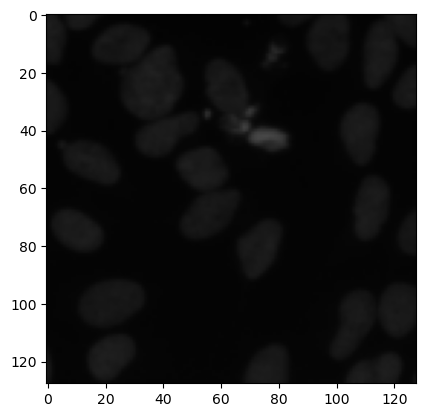

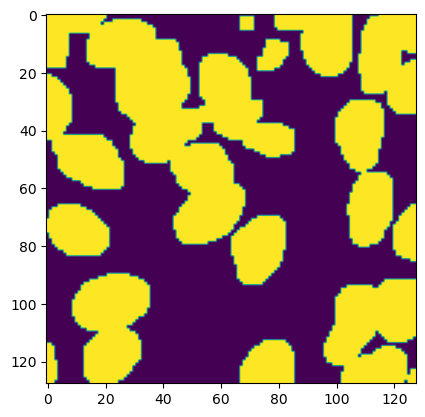

In [157]:
### Generate a random image and show it
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow



image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

### Building the U-net Model

In [161]:
seed =  42
np.random.seed = seed
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_5 (Lambda)             │ (None, 128, 128, 3)       │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_74 (Conv2D)            │ (None, 128, 128, 16)      │             448 │ lambda_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_35 (Dropout)          │ (None, 128, 128, 16)      │               0 │ conv2d_74[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_75 (Conv2D)            │ (None, 128, 128, 16)      │           2,320 │ dropout_35[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_16              │ (None, 64, 64, 16)        │               0 │ conv2d_75[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_76 (Conv2D)            │ (None, 64, 64, 32)        │           4,640 │ max_pooling2d_16[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_36 (Dropout)          │ (None, 64, 64, 32)        │               0 │ conv2d_76[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_77 (Conv2D)            │ (None, 64, 64, 32)        │           9,248 │ dropout_36[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_17              │ (None, 32, 32, 32)        │               0 │ conv2d_77[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_78 (Conv2D)            │ (None, 32, 32, 64)        │          18,496 │ max_pooling2d_17[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_37 (Dropout)          │ (None, 32, 32, 64)        │               0 │ conv2d_78[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_79 (Conv2D)            │ (None, 32, 32, 64)        │          36,928 │ dropout_37[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_18              │ (None, 16, 16, 64)        │               0 │ conv2d_79[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_80 (Conv2D)            │ (None, 16, 16, 128)       │          73,856 │ max_pooling2d_18[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_38 (Dropout)          │ (None, 16, 16, 128)       │               

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

#### Model fit takes X and y and have some other functions --- such callbacks ---  tf.keras.callbackshttps://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint 
#### in callbacks you can check weights at every epoch, save best results, early stopping and so many others --

In [164]:
### Model checkpoint

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose = 1, save_best_only = True )

callbacks =  [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir = 'logs')]

results = model.fit(X_train, Y_train , validation_split = 0.1 , batch_size = 16, epochs = 25, callbacks = callbacks)

Epoch 1/25


D:\Anaconda\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_178']. Received: the structure of inputs=*
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.7178 - loss: 0.6391 - val_accuracy: 0.7794 - val_loss: 0.4178
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.7965 - loss: 0.3656 - val_accuracy: 0.9092 - val_loss: 0.2449
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.9170 - loss: 0.2160 - val_accuracy: 0.9445 - val_loss: 0.1399
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9452 - loss: 0.1438 - val_accuracy: 0.9495 - val_loss: 0.1257
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.9460 - loss: 0.1427 - val_accuracy: 0.9489 - val_loss: 0.1307
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9504 - loss: 0.1301 - val_accuracy: 0.9558 - val_loss: 0.1107
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9531 - loss: 0.1269 - val_accuracy: 0.9549 - val_loss: 0.1175
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9521 - loss: 0.1305 - val_accuracy: 0.9595 - val

In [142]:
### Predicting the model results and showing how the models perform....

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


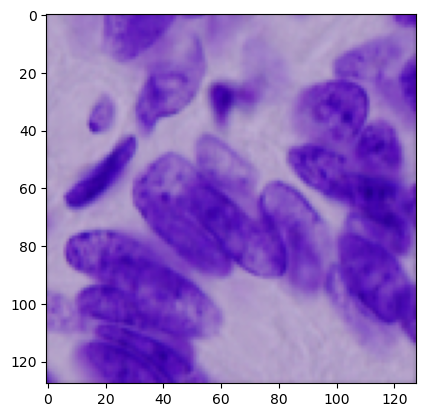

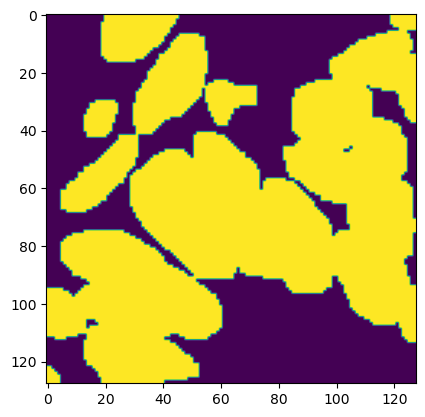

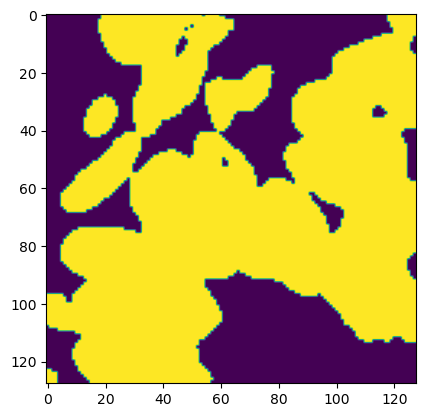

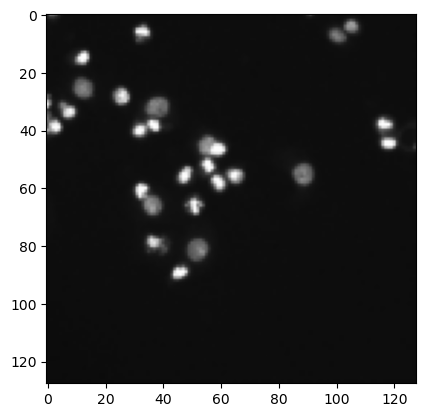

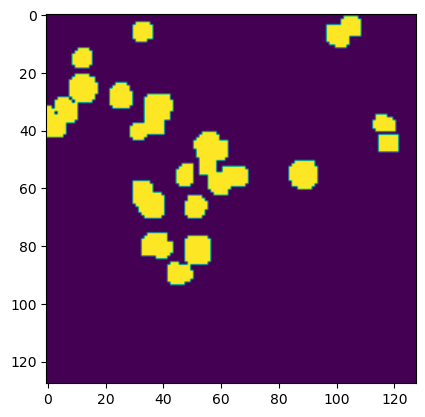

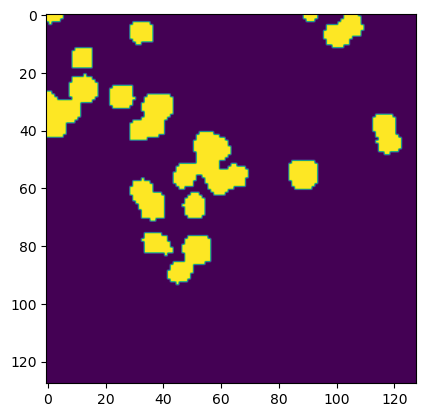

In [178]:
### randomely pick another image from train, test, and val set and check it
### Generate a random number from 0 to 670 -> total images)
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

